In [1]:
# import statements
import pandas as pd
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import loads
from pymongo import MongoClient
from datetime import datetime, timedelta
import folium as folium

# Task 1 : Streaming Data Visualization

<IPython.core.display.Javascript object>


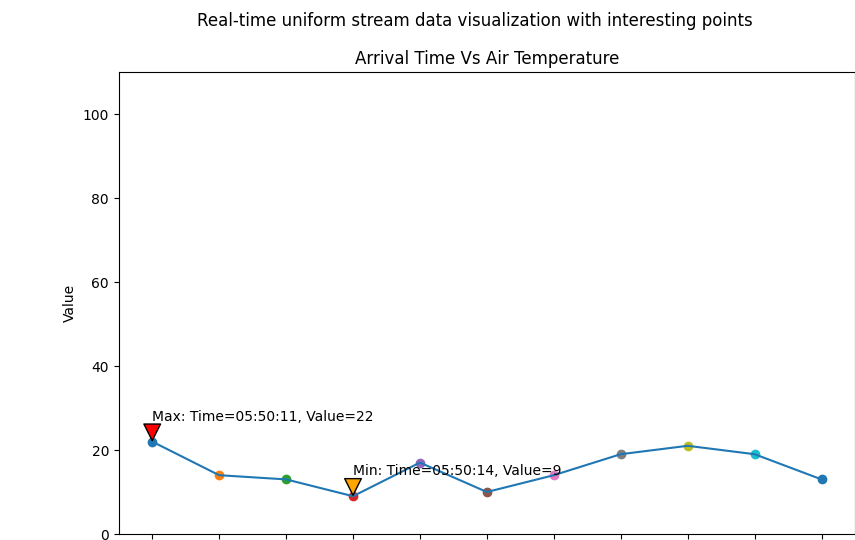

KeyboardInterrupt: 

In [2]:
# this line is needed for the inline display of graphs in Jupyter Notebook
# code referred from tutorial 10
%matplotlib notebook

topic = 'PartB'


def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   # auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Value')
        ax1.title.set_text('Arrival Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax2):
    try:
        # container for x and y values
        x2, y2 = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = loads((message.value.decode('utf-8')))
            #print(data['air_temperature_celcius'])
            y2.append(data['air_temperature_celcius']) 
            #y1.append(int(data[1]))
            x2.append(dt.datetime.now().strftime("%X")) 
          
            
            if len(y2) > 10: 
                #print('hello')
                ax2.clear()
                for xe, ye in zip(x2, y2): # we can have more than one data in one arrival time
                    ax2.scatter(xe, ye)
                ax2.plot(x2, y2)
                ax2.set_xlabel('Arrival Time')
                ax2.set_ylabel('Value')
                ax2.set_title('Arrival Time Vs Air Temperature')
                ax2.set_ylim(0,110) 
                ax2.set_yticks([0,20,40,60,80,100])
                annotate_max(x2, y2, ax2)
                annotate_min(x2, y2, ax2)
                
                fig.canvas.draw()
                x2.pop(0) # removing the item in the first position
                y2.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)

# Task 2: Static data Visualization:

In [3]:
# Create a MongoClient
client = MongoClient()

# drop the collection climate
client.fit3182_db.climate.drop()

# We will use the database: fit3182
db = client.fit3182_db

a. Plot bar chart to visualize the total number of fire records based on each hour

<IPython.core.display.Javascript object>


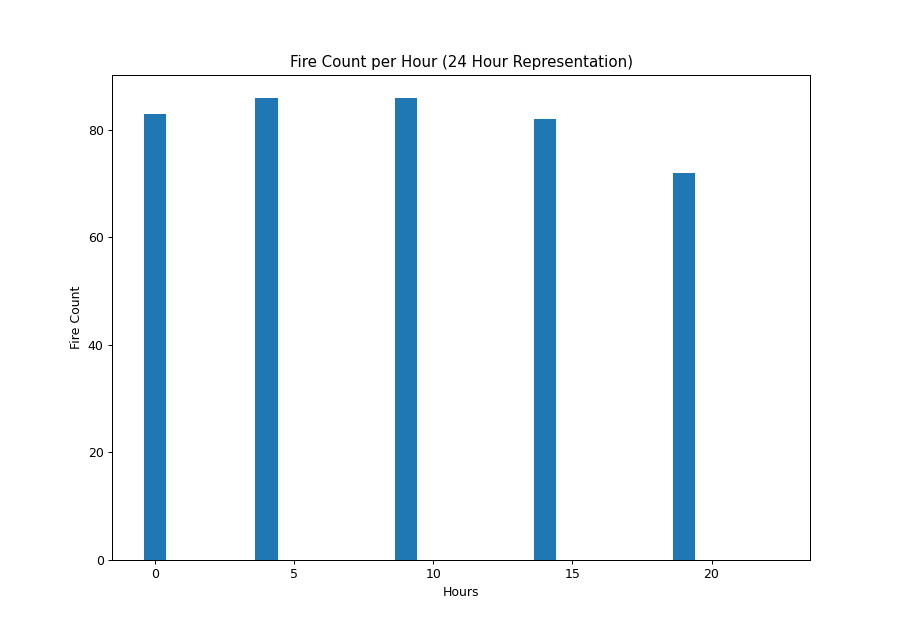

In [4]:
# Plot bar chart to visualize the total number of fire records based on each hour
pipeline=[
    {'$unwind': '$hotspot'}
]
hour_list=[]
# creating an array represent each of the hour along with the fire count
for i in range(24):
    hour_list=hour_list+[0]
#print(hour_list)

cursor=db.climate_hotspot.aggregate(pipeline)
for c in cursor:
    # check hour value
    hr_value=datetime.strptime(c['hotspot']['time'], "%H:%M:%S").hour
    hour_list[hr_value]=hour_list[hr_value]+1

# convert list to dataframe
df = pd.DataFrame (hour_list, columns = ['hours'])
index_lst=df.index.tolist()
hour_lst=df['hours']

# Figure Size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(index_lst[0:23], hour_lst[0:23])

# labels
plt.xlabel('Hours')
plt.ylabel('Fire Count')

# title 
plt.title('Fire Count per Hour (24 Hour Representation)')

# Show Plot
plt.show()


b. In a map, visualize fire locations as markers. Use 'blue' markers for 'natural' source of fire and Use 'red' markers for 'other' source of fire.

In [5]:
# get collection climate_hotspot
cursor=db.climate_hotspot.find({})
data_lst=[]

total_latitude=total_longitude=avg_latitude=avg_longitude=n=0

for data in cursor:
    total_latitude+=data['latitude']
    total_longitude+=data['longitude']
    n+=1
    data_lst.append(data)
    
# taking average of latitude and langitude for the base map representation
avg_latitude=total_latitude/n
avg_longitude=total_longitude/n

In [6]:
m=folium.Map(location=[avg_latitude, avg_longitude], zoom_start=10, tiles="Stamen Terrain")
m

In [7]:
# prompt upon taking cursor on icon
tooltip = "Click for Weather Stats!"
#print(cursor)
for i in data_lst:
    # adding air temp and relative humidity to popup descp
    popup_description=str(i['air_temperature_celcius'])+str(i['relative_humidity'])
    if len(i['hotspot'])>0:
        # iterating through the hotspot data and appending the req info to popup descp
        for hotspot_lst in i['hotspot']:
            popup_description="\n*Air Temp: "+ str(i['air_temperature_celcius'])+"\n*Relative Humidity: " +str(i['relative_humidity'])
            loc=[hotspot_lst['avg latitude'],hotspot_lst['avg longitude']]
            popup_description+="\n*Surface Tempe: "+str(hotspot_lst['avg surface_temperature_celcius'])+ "\n*Confidence: " +str(hotspot_lst['avg confidence'])
            # checking the cause of fire and adding folium icon with their resp colour accordingly
            if hotspot_lst['cause_of_fire']=="natural":
                folium.Marker(location=loc, popup=popup_description, tooltip=tooltip, icon=folium.Icon(color="blue")).add_to(m)
            elif hotspot_lst['cause_of_fire']=="other":
                folium.Marker(location=loc, popup=popup_description, tooltip=tooltip, icon=folium.Icon(color="red")).add_to(m)

In [8]:
m